In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
from pathlib import Path
from matplotlib import colormaps

In [2]:
pd.set_option('display.max_colwidth', None)
plt.rcParams.update({'font.size': 25})

In [3]:
path_to_features_train = Path.cwd() / "resources" / "lesions_features_train.csv"
path_to_features_test = Path.cwd() / "resources" / "lesions_features_test_updated_beta.csv"
path_to_patients = Path.cwd().parents[0] / "data" / "metadata" / "patients.csv"
path_to_series = Path.cwd().parents[0] / "data" / "metadata" / "series.json"
savefig = False
savecsv = False
dpi = 300

In [4]:
# Add patient info to series
patients_df = pd.read_csv(path_to_patients)
with open(path_to_series, 'r') as file:
    series_df = pd.DataFrame(json.load(file))
series_df.drop(columns='patient_code', inplace=True)
series_df = series_df.merge(
    patients_df,
    on=['patient_id'],
    how='left'
)

In [5]:
# Read dataframe
df = pd.read_csv(path_to_features_train)
df["subset"] = "train"
test_df = pd.read_csv(path_to_features_test)
test_df["subset"] = "test"
df = pd.concat([df, test_df], ignore_index=True)
df["uuid"] = df["filename"].apply(lambda x: x.split('.nii.gz')[0])
df["lesion_type"] = df["label_description"].apply(lambda x: x.split(',')[0])
df["lesion_location"] = df["label_description"].apply(lambda x: x.split(',')[1])
columns = [
    'patient_id',
    'uuid',
    'sex',
    'age',
    'diagnosis'
]
df = df.merge(
    series_df[columns],
    on=['uuid'],
    how='left'
)
display(df.describe())

,label_value,voxels_count,volume_ml,slices_count,mean_HU,std_HU,major_axis,minor_axis,major_axis_slice_idx,patient_id,age
count,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000
mean,77.447068,6144.345277,4.927334,9.480456,-59.429418,184.330347,17.012723,10.505048,138.422638,21.538274,49.582248
std,82.841743,32105.704609,29.690234,8.549989,113.058407,95.548331,18.399322,10.369648,60.617534,8.238657,12.685677
min,1.000000,52.000000,0.014461,2.000000,-680.534400,10.485603,2.910678,0.000000,11.000000,1.000000,37.000000
25%,9.000000,400.000000,0.148855,4.000000,-124.543148,147.796025,8.107163,5.609765,89.750000,12.000000,37.000000
50%,45.000000,1083.500000,0.416738,7.000000,-57.334940,218.308990,11.812193,7.876468,134.000000,28.000000,56.000000
75%,125.250000,2734.250000,1.279960,11.000000,28.906702,246.678105,18.652045,11.168649,181.000000,28.000000,57.000000
max,314.000000,799981.000000,719.045727,88.000000,196.468120,394.051570,198.395296,117.515563,335.000000,44.000000,75.000000


In [6]:
# Lung and Liver tumors
subset_df = df[
    df["lesion_location"].isin(["lung", "liver"]) &
    df["lesion_type"].isin(["t", "m"])
].copy()
grouped = subset_df.groupby(['lesion_location', 'subset']).size().reset_index(name="lesions_count")
display(grouped)
grouped = subset_df.groupby(['lesion_location', 'subset'])["filename"].nunique().reset_index(name="images")
display(grouped)
grouped = subset_df.groupby(['lesion_location', 'subset'])["patient_id"].nunique().reset_index(name="patient_count")
display(grouped)
grouped = subset_df.groupby(['lesion_location', 'subset'])["volume_ml"].sum().reset_index(name="annotated_volume_ml")
display(grouped)
grouped = subset_df.groupby(['lesion_location'])["volume_ml"].sum().reset_index(name="annotated_volume_ml")
display(grouped)

,lesion_location,subset,lesions_count
0,liver,test,84
1,liver,train,101
2,lung,test,521
3,lung,train,410


,lesion_location,subset,images
0,liver,test,5
1,liver,train,16
2,lung,test,5
3,lung,train,16


,lesion_location,subset,patient_count
0,liver,test,2
1,liver,train,7
2,lung,test,2
3,lung,train,8


,lesion_location,subset,annotated_volume_ml
0,liver,test,1915.822204
1,liver,train,1058.095994
2,lung,test,320.962793
3,lung,train,557.857908


,lesion_location,annotated_volume_ml
0,liver,2973.918197
1,lung,878.820701


In [7]:
# Individual CT information: Add annotated lesions and annotated volume
subset = [
    'filename',
    'subset',
    'patient_id',
    'sex',
    'age',
    'diagnosis',
    'lesion_location'
]
cts_df = subset_df.groupby(subset).agg(
    lesions_count=('filename', 'size'),
    annotated_volume_ml= ('volume_ml', 'sum')
).reset_index()
cts_df.sort_values(by=['lesion_location', 'subset', 'filename'], inplace=True, ignore_index=True)
# Add stats for individual lesions volumes
mapping = {
    "mean": "volume_ml_mean",
    "std": "volume_ml_std",
    "min": "volume_ml_min",
    "25%": "volume_ml_Q25",
    "50%": "volume_ml_Q50",
    "75%": "volume_ml_Q75",
    "max": "volume_ml_max"
}
grouped = subset_df.groupby(['filename', 'subset', 'lesion_location'])['volume_ml'].describe().reset_index()
grouped.rename(columns=mapping, inplace=True)
cts_df = cts_df.merge(
    grouped[['filename'] + list(mapping.values())],
    on='filename',
    how='left'
)
display(cts_df)

,filename,subset,patient_id,sex,age,diagnosis,lesion_location,lesions_count,annotated_volume_ml,volume_ml_mean,volume_ml_std,volume_ml_min,volume_ml_Q25,volume_ml_Q50,volume_ml_Q75,volume_ml_max
0,1.3.12.2.1107.5.1.4.83504.30000021051412400662100001857.nii.gz,test,28,F,37,colon cancer,liver,39,395.214133,10.133696,60.402852,0.098063,0.158038,0.263543,0.640909,377.663556
1,1.3.12.2.1107.5.1.4.83504.30000021061014315422700023041.nii.gz,test,13,M,58,gastric cancer,liver,2,368.310327,184.155164,97.858533,114.958731,149.556947,184.155164,218.753380,253.351596
2,1.3.12.2.1107.5.1.4.83504.30000021071911510369800020299.nii.gz,test,28,F,37,colon cancer,liver,39,804.022772,20.615969,114.941288,0.103365,0.253470,0.418854,1.246675,719.045727
3,1.3.12.2.1107.5.1.4.83504.30000021081905213109000029485.nii.gz,test,13,M,58,gastric cancer,liver,2,208.918759,104.459379,67.894053,56.451034,80.455207,104.459379,128.463552,152.467725
4,1.3.12.2.1107.5.1.4.83504.30000021102112360685900001538.nii.gz,test,13,M,58,gastric cancer,liver,2,139.356213,69.678106,41.004093,40.683834,55.180970,69.678106,84.175242,98.672379
5,1.3.12.2.1107.5.1.4.83504.30000020102916421550900016665.nii.gz,train,22,M,64,colon cancer,liver,8,146.553982,18.319248,28.351044,0.326395,0.962865,2.286724,24.832134,65.987937
6,1.3.12.2.1107.5.1.4.83504.30000020121611411612500007509.nii.gz,train,24,F,75,gastric cancer,liver,17,238.828950,14.048762,20.305970,1.099184,2.082082,6.124423,14.775308,80.437038
7,1.3.12.2.1107.5.1.4.83504.30000021011202081810900017615.nii.gz,train,22,M,64,colon cancer,liver,14,152.772835,10.912345,34.447375,0.190511,0.406834,0.795231,1.394112,130.106909
8,1.3.12.2.1107.5.1.4.83504.30000021031714114711900009696.nii.gz,train,22,M,64,colon cancer,liver,11,181.101791,16.463799,44.193883,0.302811,0.569778,1.081467,4.324013,148.813522
9,1.3.12.2.1107.5.1.4.83504.30000021052612201586400049605.nii.gz,train,7,M,53,rectal cancer,liver,6,22.342190,3.723698,2.816610,0.893746,1.380714,3.136859,5.935100,7.511548


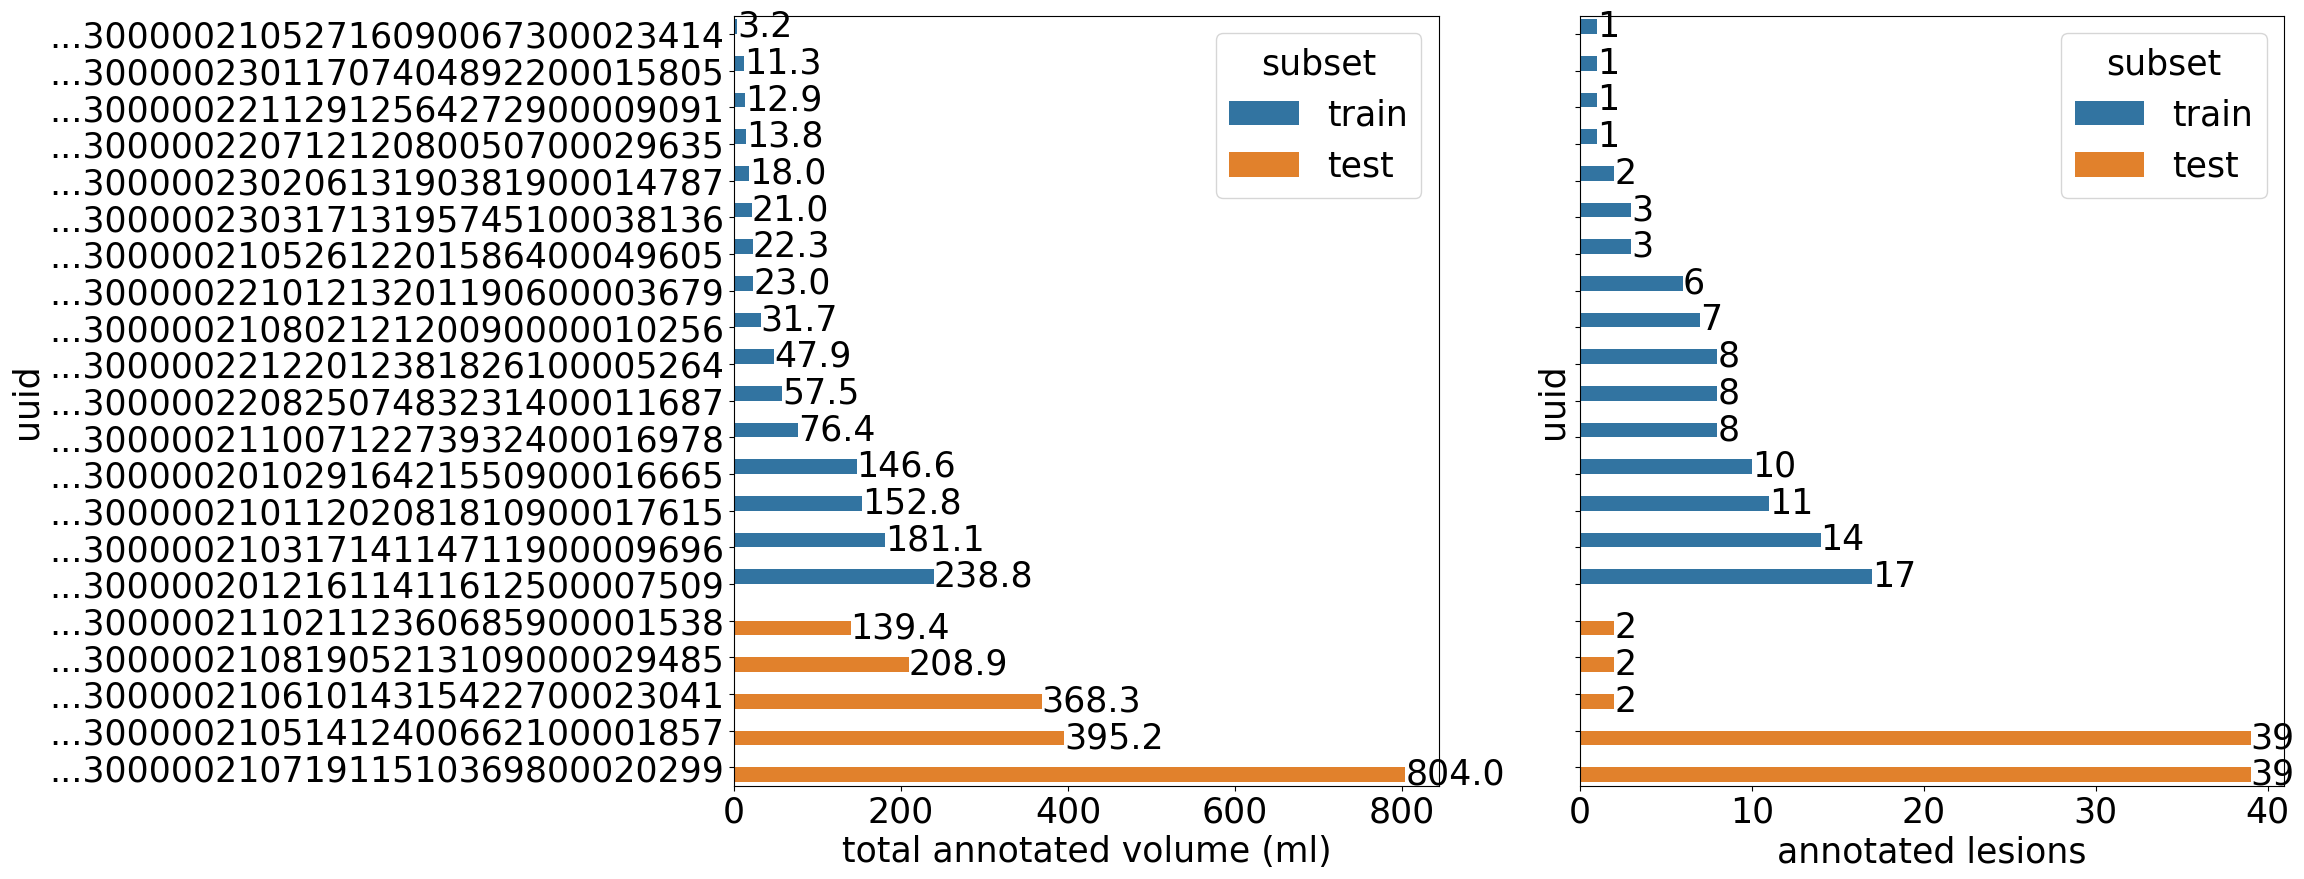

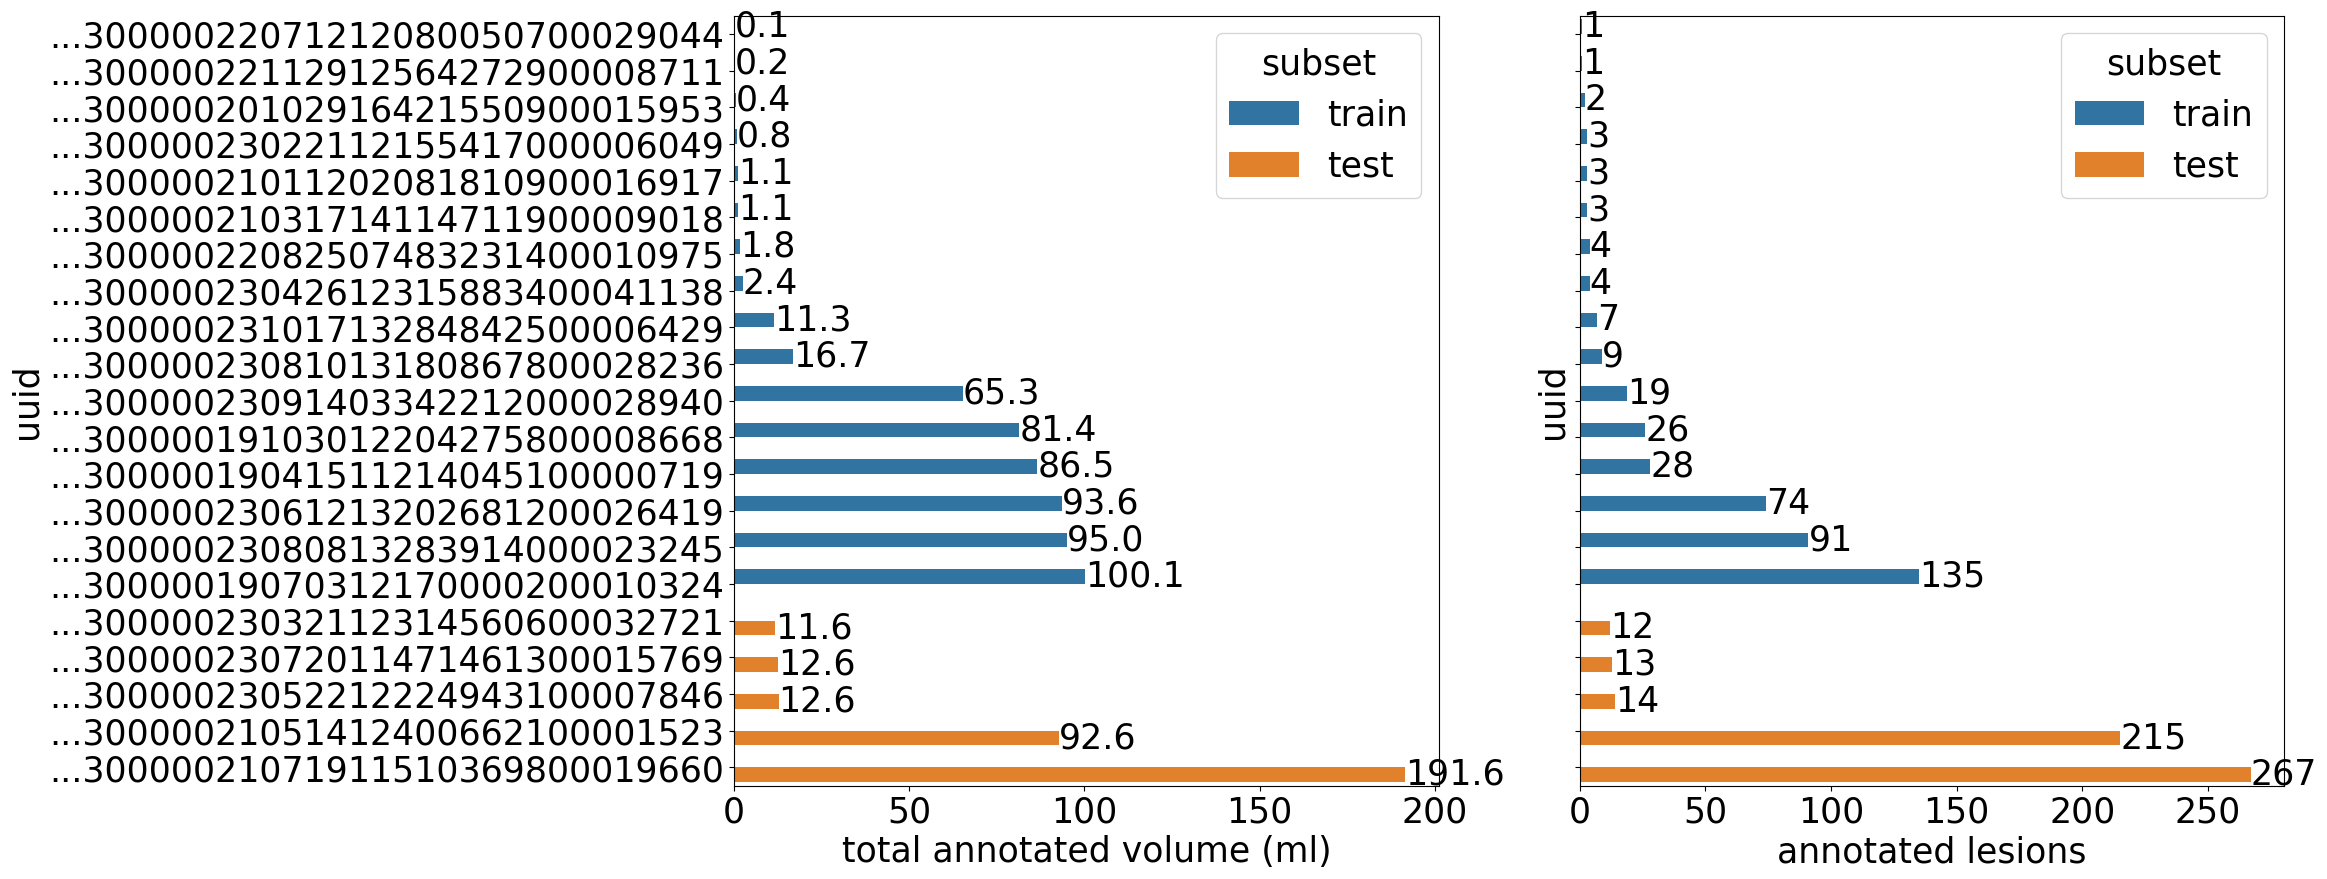

In [8]:
cts_df['uuid'] = cts_df.apply(lambda x: Path(x['filename']).name.split('.nii.gz')[0], axis=1)
cts_df['short_uuid'] = cts_df['uuid'].apply(lambda x: f"...{str(x).split('.')[-1]}")
for organ in cts_df['lesion_location'].unique():
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    hue_colors = {
        "train": plt.get_cmap('tab10')(0),
        "test": plt.get_cmap('tab10')(1)
    }
    # annotated volume
    sns.barplot(
        data=cts_df[cts_df['lesion_location'] == organ].sort_values(by=['subset', 'annotated_volume_ml'], ascending=[False, True], ignore_index=True),
        x='annotated_volume_ml',
        y='short_uuid',
        hue='subset',
        dodge=True,
        orient='h',
        palette=hue_colors,
        ax=ax[0]
    )
    #ax.bar_label(ax.containers[0], fontsize=10, fmt='%.1f')
    #ax.bar_label(ax.containers[1], fontsize=10, fmt='%.1f')
    ax[0].bar_label(ax[0].containers[0], fmt='%.1f')
    ax[0].bar_label(ax[0].containers[1], fmt='%.1f')
    ax[0].set_xlabel('total annotated volume (ml)')
    ax[0].set_ylabel('uuid')
    # annotated lesions
    sns.barplot(
        data=cts_df[cts_df['lesion_location'] == organ].sort_values(by=['subset', 'lesions_count'], ascending=[False, True], ignore_index=True),
        x='lesions_count',
        y='short_uuid',
        hue='subset',
        dodge=True,
        orient='h',
        palette=hue_colors,
        ax=ax[1]
    )
    ax[1].set_xlabel('annotated lesions')
    ax[1].set_ylabel('uuid')
    ax[1].tick_params(labelleft=False)
    ax[1].bar_label(ax[1].containers[0], fmt='%i')
    ax[1].bar_label(ax[1].containers[1], fmt='%i')
    if savefig:
        plt.savefig(
            Path.cwd() / "results" / f"nnunet_{organ}_annotated_volume_vs_lesions_count.png",
            transparent=True,
            bbox_inches='tight',
            dpi=dpi
        )
    plt.show()

In [9]:
# Individual lesion stats grouped by location, subset and filename
props = [
    'volume_ml',
    'slices_count',
    'mean_HU',
    'std_HU',
    'major_axis'
]
cts_lesions_props_df = subset_df.groupby(['lesion_location', 'subset', 'filename'])[props].describe().reset_index()
cts_lesions_props_df.columns = [
    '_'.join(map(str, col)) if col[-1] != '' else str(col[0])
    for col in cts_lesions_props_df.columns
]
cts_lesions_props_df = cts_lesions_props_df.merge(
    cts_df[['filename', 'patient_id', 'age', 'diagnosis', 'annotated_volume_ml', 'uuid']],
    on='filename',
    how='left'
)
cts_lesions_props_df['short_uuid'] = cts_lesions_props_df['uuid'].apply(lambda x: f"...{str(x).split('.')[-1][-4:]}")
cts_lesions_props_df.rename(columns={'volume_ml_count': 'lesions_count'}, inplace=True)
if savecsv:
    cts_lesions_props_df.to_csv(
        Path.cwd() / "results" / "nnunet_cts_lesions_properties.csv",
        index=False
    )
display(cts_lesions_props_df)

,lesion_location,subset,filename,lesions_count,volume_ml_mean,volume_ml_std,volume_ml_min,volume_ml_25%,volume_ml_50%,volume_ml_75%,...,major_axis_25%,major_axis_50%,major_axis_75%,major_axis_max,patient_id,age,diagnosis,annotated_volume_ml,uuid,short_uuid
0,liver,test,1.3.12.2.1107.5.1.4.83504.30000021051412400662100001857.nii.gz,39.0,10.133696,60.402852,0.098063,0.158038,0.263543,0.640909,...,7.898813,10.185412,13.755514,183.614494,28,37,colon cancer,395.214133,1.3.12.2.1107.5.1.4.83504.30000021051412400662100001857,...1857
1,liver,test,1.3.12.2.1107.5.1.4.83504.30000021061014315422700023041.nii.gz,2.0,184.155164,97.858533,114.958731,149.556947,184.155164,218.753380,...,89.767558,90.714536,91.661513,92.608490,13,58,gastric cancer,368.310327,1.3.12.2.1107.5.1.4.83504.30000021061014315422700023041,...3041
2,liver,test,1.3.12.2.1107.5.1.4.83504.30000021071911510369800020299.nii.gz,39.0,20.615969,114.941288,0.103365,0.253470,0.418854,1.246675,...,8.402906,10.310158,14.016085,175.779640,28,37,colon cancer,804.022772,1.3.12.2.1107.5.1.4.83504.30000021071911510369800020299,...0299
3,liver,test,1.3.12.2.1107.5.1.4.83504.30000021081905213109000029485.nii.gz,2.0,104.459379,67.894053,56.451034,80.455207,104.459379,128.463552,...,82.289901,82.710072,83.130244,83.550415,13,58,gastric cancer,208.918759,1.3.12.2.1107.5.1.4.83504.30000021081905213109000029485,...9485
4,liver,test,1.3.12.2.1107.5.1.4.83504.30000021102112360685900001538.nii.gz,2.0,69.678106,41.004093,40.683834,55.180970,69.678106,84.175242,...,70.573958,70.704716,70.835475,70.966233,13,58,gastric cancer,139.356213,1.3.12.2.1107.5.1.4.83504.30000021102112360685900001538,...1538
5,liver,train,1.3.12.2.1107.5.1.4.83504.30000020102916421550900016665.nii.gz,8.0,18.319248,28.351044,0.326395,0.962865,2.286724,24.832134,...,13.398166,23.724356,44.465896,71.945641,22,64,colon cancer,146.553982,1.3.12.2.1107.5.1.4.83504.30000020102916421550900016665,...6665
6,liver,train,1.3.12.2.1107.5.1.4.83504.30000020121611411612500007509.nii.gz,17.0,14.048762,20.305970,1.099184,2.082082,6.124423,14.775308,...,20.263304,31.674322,49.411331,77.691716,24,75,gastric cancer,238.828950,1.3.12.2.1107.5.1.4.83504.30000020121611411612500007509,...7509
7,liver,train,1.3.12.2.1107.5.1.4.83504.30000021011202081810900017615.nii.gz,14.0,10.912345,34.447375,0.190511,0.406834,0.795231,1.394112,...,9.549274,14.209699,19.916061,145.453049,22,64,colon cancer,152.772835,1.3.12.2.1107.5.1.4.83504.30000021011202081810900017615,...7615
8,liver,train,1.3.12.2.1107.5.1.4.83504.30000021031714114711900009696.nii.gz,11.0,16.463799,44.193883,0.302811,0.569778,1.081467,4.324013,...,11.421927,18.070074,31.740429,135.051997,22,64,colon cancer,181.101791,1.3.12.2.1107.5.1.4.83504.30000021031714114711900009696,...9696
9,liver,train,1.3.12.2.1107.5.1.4.83504.30000021052612201586400049605.nii.gz,6.0,3.723698,2.816610,0.893746,1.380714,3.136859,5.935100,...,17.296242,22.210406,24.263773,33.443968,7,53,rectal cancer,22.342190,1.3.12.2.1107.5.1.4.83504.30000021052612201586400049605,...9605


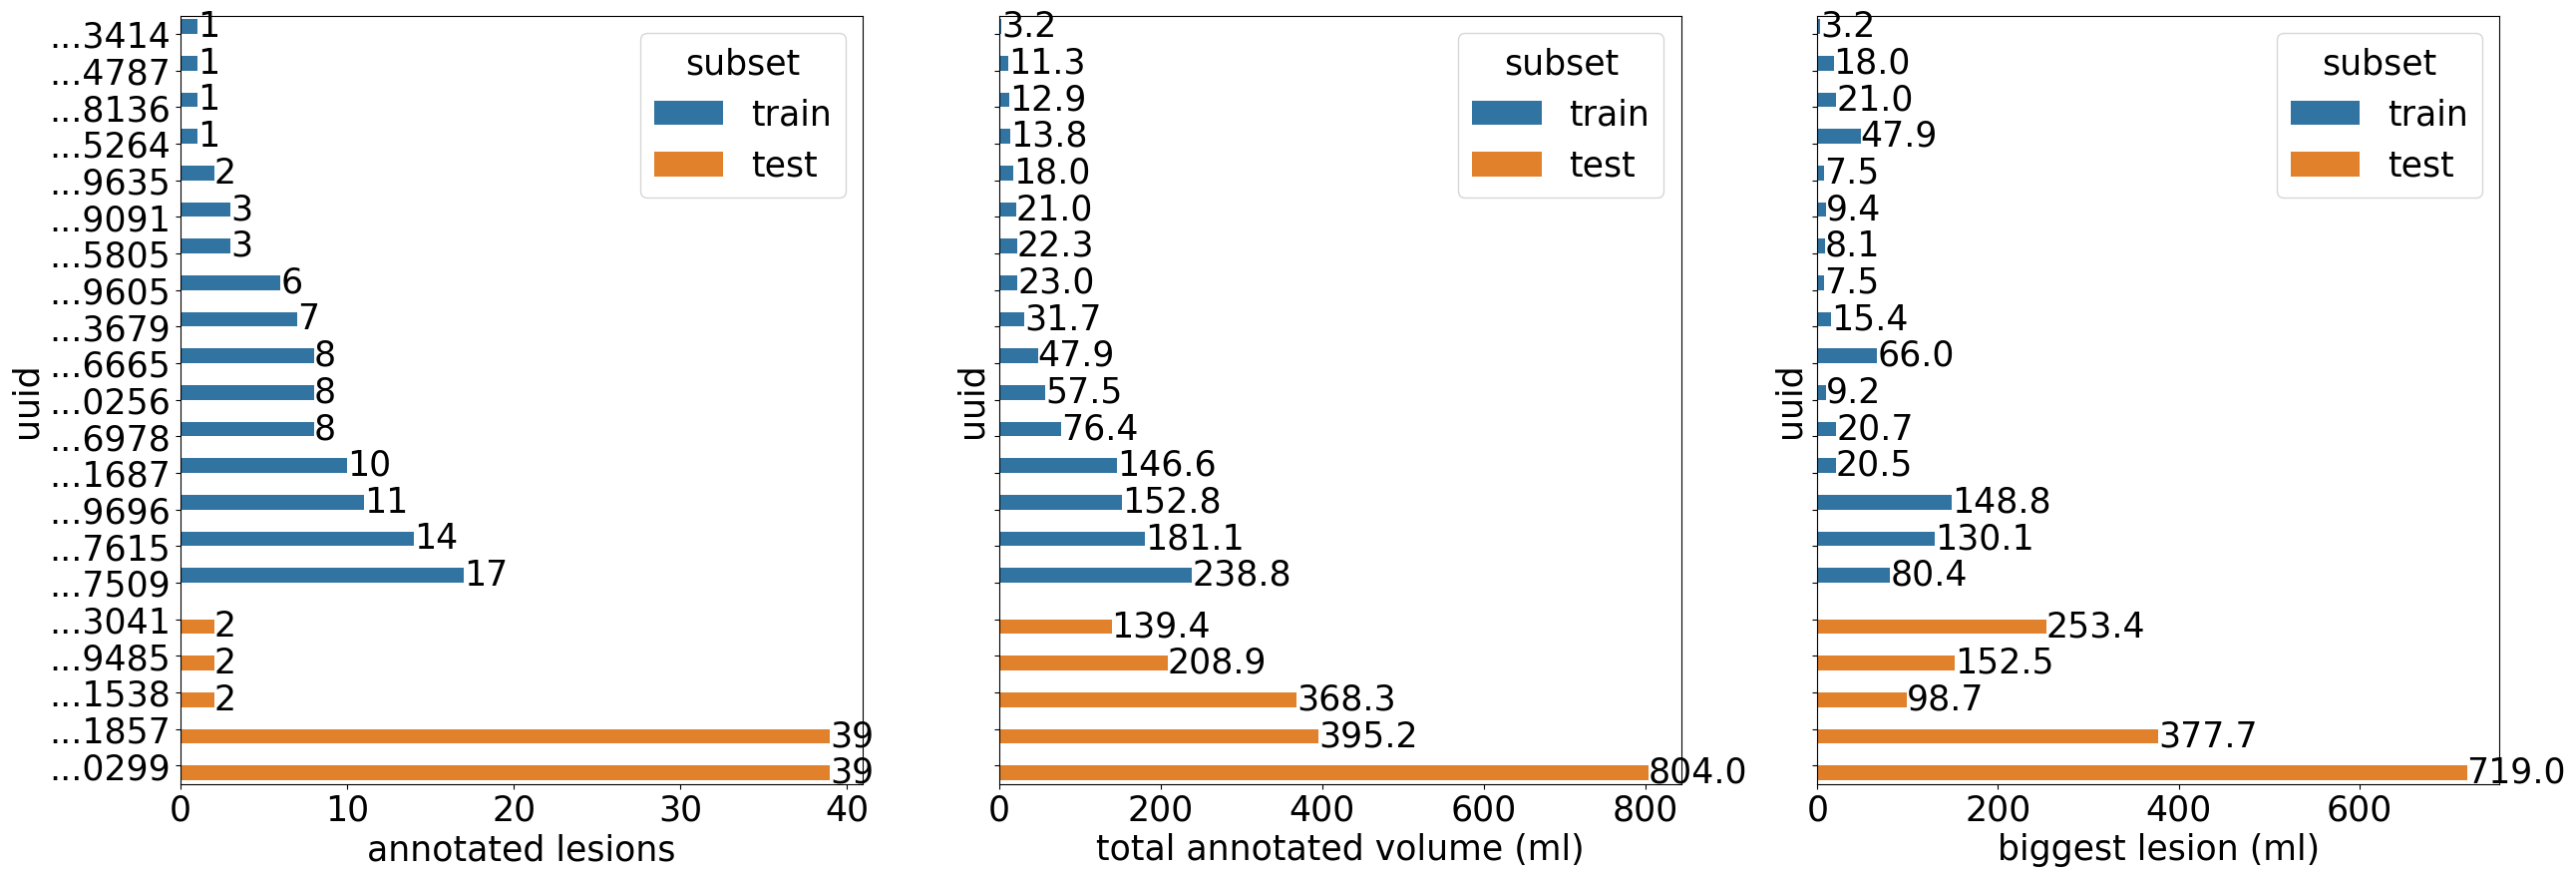

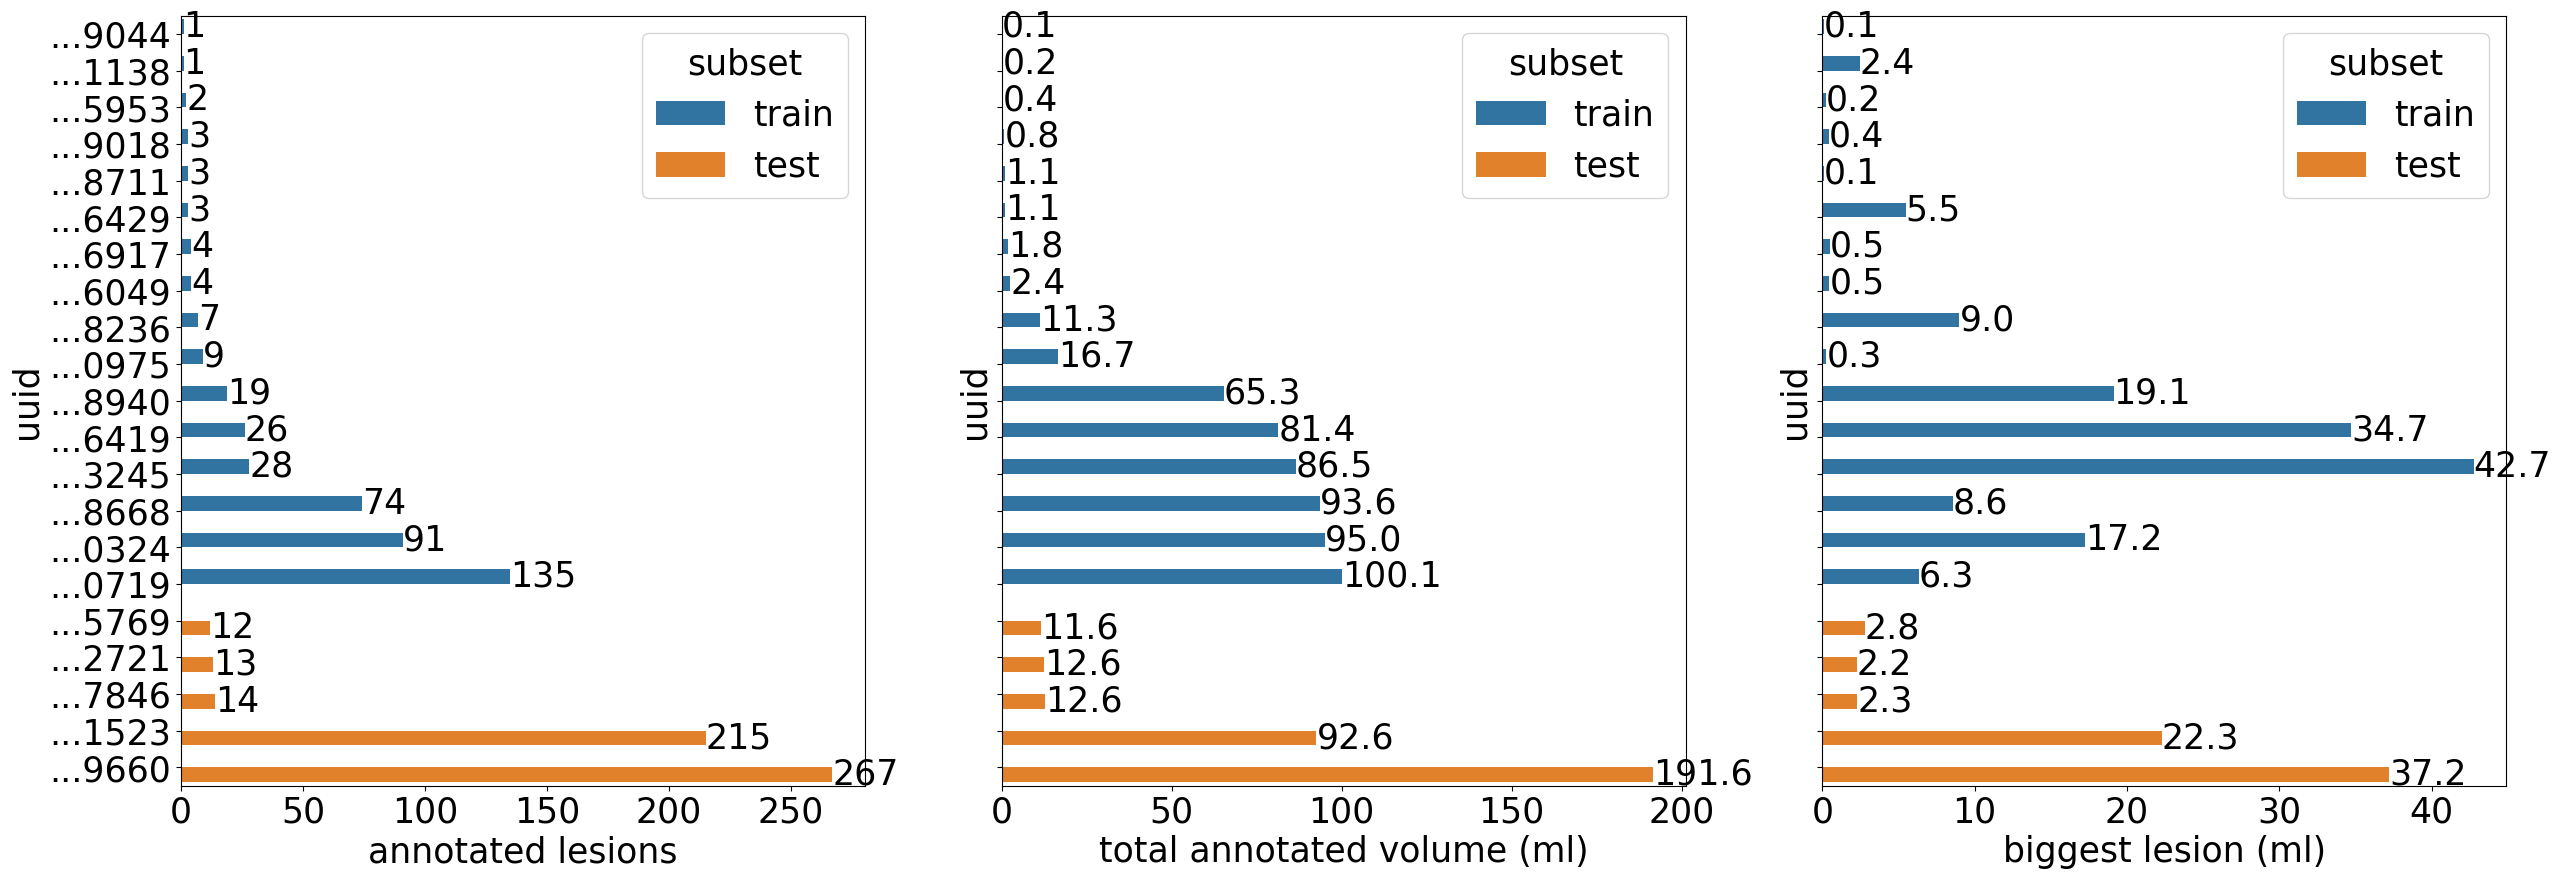

In [10]:
# Barplots considering annotated volume, annotated lesions and biggest annotated lesion
for organ in cts_lesions_props_df['lesion_location'].unique():
    _, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,10))
    hue_colors = {
        "train": plt.get_cmap('tab10')(0),
        "test": plt.get_cmap('tab10')(1)
    }
    # annotated lesions
    sns.barplot(
        data=cts_lesions_props_df[cts_lesions_props_df['lesion_location'] == organ].sort_values(by=['subset', 'lesions_count'], ascending=[False, True], ignore_index=True),
        x='lesions_count',
        y='short_uuid',
        hue='subset',
        dodge=True,
        orient='h',
        palette=hue_colors,
        ax=ax[0]
    )
    ax[0].set_xlabel('annotated lesions')
    ax[0].set_ylabel('uuid')
    ax[0].bar_label(ax[0].containers[0], fmt='%i')
    ax[0].bar_label(ax[0].containers[1], fmt='%i')
    # annotated volume
    sns.barplot(
        data=cts_lesions_props_df[cts_lesions_props_df['lesion_location'] == organ].sort_values(by=['subset', 'annotated_volume_ml'], ascending=[False, True], ignore_index=True),
        x='annotated_volume_ml',
        y='short_uuid',
        hue='subset',
        dodge=True,
        orient='h',
        palette=hue_colors,
        ax=ax[1]
    )
    ax[1].bar_label(ax[1].containers[0], fmt='%.1f')
    ax[1].bar_label(ax[1].containers[1], fmt='%.1f')
    ax[1].tick_params(labelleft=False)
    ax[1].set_xlabel('total annotated volume (ml)')
    ax[1].set_ylabel('uuid')
    # biggest lesion
    sns.barplot(
        data=cts_lesions_props_df[cts_lesions_props_df['lesion_location'] == organ].sort_values(by=['subset', 'lesions_count'], ascending=[False, True], ignore_index=True),
        x='volume_ml_max',
        y='short_uuid',
        hue='subset',
        dodge=True,
        orient='h',
        palette=hue_colors,
        ax=ax[2]
    )
    ax[2].set_xlabel('biggest lesion (ml)')
    ax[2].set_ylabel('uuid')
    ax[2].tick_params(labelleft=False)
    ax[2].bar_label(ax[2].containers[0], fmt='%.1f')
    ax[2].bar_label(ax[2].containers[1], fmt='%.1f')
    if savefig:
        plt.savefig(
            Path.cwd() / "results" / f"nnunet_{organ}_lesions_count_vs_annotated_volume_vs_biggest_lesion.png",
            transparent=True,
            bbox_inches='tight',
            dpi=dpi
        )
    plt.show()

In [11]:
# Short version of dataframe with CT lesions properties
subset = [
    'lesion_location',
    'short_uuid',
    'subset',
    'patient_id',
    'diagnosis',
    'lesions_count',
    'annotated_volume_ml',
    'volume_ml_max',
    'mean_HU_mean'
]
cts_lesions_props_subset_df = cts_lesions_props_df[subset].copy()
for col in ['annotated_volume_ml', 'volume_ml_max', 'mean_HU_mean']:
    cts_lesions_props_subset_df[col] = cts_lesions_props_subset_df[col].apply(lambda x: f'{x:.1f}')
cts_lesions_props_subset_df['lesions_count'] = cts_lesions_props_subset_df['lesions_count'].apply(lambda x: f'{x:.0f}')
display(cts_lesions_props_subset_df)
if savecsv:
    for organ in cts_lesions_props_subset_df['lesion_location'].unique():
        df = cts_lesions_props_subset_df[cts_lesions_props_subset_df['lesion_location'] == organ].sort_values(by=['subset', 'lesions_count'], ascending=[False, True])
        df.to_csv(Path.cwd() / 'results' / f'nnunet_cts_lesions_properties_{organ}_short_version.csv', index=False)

,lesion_location,short_uuid,subset,patient_id,diagnosis,lesions_count,annotated_volume_ml,volume_ml_max,mean_HU_mean
0,liver,...1857,test,28,colon cancer,39,395.2,377.7,106.4
1,liver,...3041,test,13,gastric cancer,2,368.3,253.4,75.4
2,liver,...0299,test,28,colon cancer,39,804.0,719.0,89.9
3,liver,...9485,test,13,gastric cancer,2,208.9,152.5,46.7
4,liver,...1538,test,13,gastric cancer,2,139.4,98.7,50.2
5,liver,...6665,train,22,colon cancer,8,146.6,66.0,86.9
6,liver,...7509,train,24,gastric cancer,17,238.8,80.4,85.6
7,liver,...7615,train,22,colon cancer,14,152.8,130.1,75.6
8,liver,...9696,train,22,colon cancer,11,181.1,148.8,61.1
9,liver,...9605,train,7,rectal cancer,6,22.3,7.5,64.2
